In [1]:
# ...
# Here we instead use the convenient InteractiveSession class,
# which makes TensorFlow more flexible about how you structure your code.
# It allows you to interleave operations which build a computation graph with ones that run the graph.
# This is particularly convenient when working in interactive contexts like IPython.
# If you are not using an InteractiveSession,
# then you should build the entire computation graph
# before starting a session and launching the graph.
# ...
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

sess = tf.InteractiveSession()


Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


In [2]:
# ...
# Placeholders
# We start building the computation graph by creating nodes for the input images and target output classes.
# ...
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])


In [3]:
# ...
# We now define the weights W and biases b for our model.
# We pass the initial value for each parameter in the call to tf.
# Variable. In this case, we initialize both W and b as tensors full of zeros.
# W is a 784x10 matrix (because we have 784 input features and 10 outputs) and
# b is a 10-dimensional vector (because we have 10 classes).
# ...
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))


In [4]:
#Initialize variables for this session
sess.run(tf.global_variables_initializer())

In [5]:
# ...
# We can now implement our regression model.
# We multiply the vectorized input images x 
# by the weight matrix W, add the bias b.
# ...
y = tf.matmul(x,W) + b

In [6]:
# our loss function is the cross-entropy between the target and the softmax activation function applied to the model's prediction.
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))


In [7]:
# Train the Model

# Now that we have defined our model and training loss function, it is straightforward to train using TensorFlow. Because TensorFlow knows the entire computation graph, it can use automatic differentiation to find the gradients of the loss with respect to each of the variables. TensorFlow has a variety of built-in optimization algorithms. For this example, we will use steepest gradient descent, with a step length of 0.5, to descend the cross entropy.

train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)


In [8]:
# The returned operation train_step, when run, will apply the gradient descent updates to the parameters. Training the model can therefore be accomplished by repeatedly running train_step.

for _ in range(1000):
  batch = mnist.train.next_batch(100)
  train_step.run(feed_dict={x: batch[0], y_: batch[1]})


In [9]:
# Evaluate the Model

# How well did our model do?

# First we'll figure out where we predicted the correct label. tf.argmax is an extremely useful function which gives you the index of the highest entry in a tensor along some axis. For example, tf.argmax(y,1) is the label our model thinks is most likely for each input, while tf.argmax(y_,1) is the true label. We can use tf.equal to check if our prediction matches the truth.

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

# That gives us a list of booleans. To determine what fraction are correct, we cast to floating point numbers and then take the mean. For example, [True, False, True, True] would become [1,0,1,1] which would become 0.75.

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Finally, we can evaluate our accuracy on the test data. This should be about 92% correct.

print(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))



0.9189


In [23]:
# Build a Multilayer Convolutional Network
# Weight Initialization

# To create this model, we're going to need to create a lot of weights and biases. One should generally initialize weights with a small amount of noise for symmetry breaking, and to prevent 0 gradients. Since we're using ReLU neurons, it is also good practice to initialize them with a slightly positive initial bias to avoid "dead neurons". Instead of doing this repeatedly while we build the model, let's create two handy functions to do it for us.

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)


In [24]:
# Convolution and Pooling

# TensorFlow also gives us a lot of flexibility in convolution and pooling operations. How do we handle the boundaries? What is our stride size? In this example, we're always going to choose the vanilla version. Our convolutions uses a stride of one and are zero padded so that the output is the same size as the input. Our pooling is plain old max pooling over 2x2 blocks. To keep our code cleaner, let's also abstract those operations into functions.

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')


In [25]:
# First Convolutional Layer

# We can now implement our first layer. It will consist of convolution, followed by max pooling. The convolution will compute 32 features for each 5x5 patch. Its weight tensor will have a shape of [5, 5, 1, 32]. The first two dimensions are the patch size, the next is the number of input channels, and the last is the number of output channels. We will also have a bias vector with a component for each output channel.

W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

# To apply the layer, we first reshape x to a 4d tensor, with the second and third dimensions corresponding to image width and height, and the final dimension corresponding to the number of color channels.

x_image = tf.reshape(x, [-1, 28, 28, 1])

# We then convolve x_image with the weight tensor, add the bias, apply the ReLU function, and finally max pool. The max_pool_2x2 method will reduce the image size to 14x14.

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)


In [26]:
# Second Convolutional Layer

# In order to build a deep network, we stack several layers of this type. The second layer will have 64 features for each 5x5 patch.

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)


In [27]:
# Densely Connected Layer

# Now that the image size has been reduced to 7x7, we add a fully-connected layer with 1024 neurons to allow processing on the entire image. We reshape the tensor from the pooling layer into a batch of vectors, multiply by a weight matrix, add a bias, and apply a ReLU.

W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)


In [28]:
# Dropout

# To reduce overfitting, we will apply dropout before the readout layer. We create a placeholder for the probability that a neuron's output is kept during dropout. This allows us to turn dropout on during training, and turn it off during testing. TensorFlow's tf.nn.dropout op automatically handles scaling neuron outputs in addition to masking them, so dropout just works without any additional scaling.1

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)


In [29]:
# Readout Layer

# Finally, we add a layer, just like for the one layer softmax regression above.

W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [ ]:
# Train and Evaluate the Model

# How well does this model do? To train and evaluate it we will use code that is nearly identical to that for the simple one layer SoftMax network above.

# The differences are that:

#  ~   We will replace the steepest gradient descent optimizer with the more sophisticated ADAM optimizer.

#  ~   We will include the additional parameter keep_prob in feed_dict to control the dropout rate.

#  ~   We will add logging to every 100th iteration in the training process.

# We will also use tf.Session rather than tf.InteractiveSession. This better separates the process of creating the graph (model specification) and the process of evaluating the graph (model fitting). It generally makes for cleaner code. The tf.Session is created within a with block so that it is automatically destroyed once the block is exited.
 
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(20000):
    batch = mnist.train.next_batch(50)
    if i % 100 == 0:
      train_accuracy = accuracy.eval(feed_dict={
          x: batch[0], y_: batch[1], keep_prob: 1.0})
      print('step %d, training accuracy %g' % (i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

  print('test accuracy %g' % accuracy.eval(feed_dict={
      x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

  print('USPS accuracy %g' % accuracy.eval(feed_dict={
      x: USPS_img_array, y_: USPS_label_array, keep_prob: 1.0}))  
    

step 0, training accuracy 0.1
step 100, training accuracy 0.82
step 200, training accuracy 0.86
step 300, training accuracy 0.92
step 400, training accuracy 0.92
step 500, training accuracy 0.98
step 600, training accuracy 1
step 700, training accuracy 0.96
step 800, training accuracy 0.98
step 900, training accuracy 0.94
step 1000, training accuracy 0.96
step 1100, training accuracy 0.98
step 1200, training accuracy 1
step 1300, training accuracy 0.96
step 1400, training accuracy 1
step 1500, training accuracy 0.98
step 1600, training accuracy 0.94
step 1700, training accuracy 0.98
step 1800, training accuracy 1
step 1900, training accuracy 1
step 2000, training accuracy 0.94
step 2100, training accuracy 0.98
step 2200, training accuracy 0.96
step 2300, training accuracy 0.98
step 2400, training accuracy 0.96
step 2500, training accuracy 0.98
step 2600, training accuracy 0.96
step 2700, training accuracy 1
step 2800, training accuracy 0.96
step 2900, training accuracy 0.96
step 3000, 

In [10]:
def get_my_usps_data(): 
    import zipfile
    import os
    from PIL import Image
    import PIL.ImageOps  
    import numpy as np
    import tensorflow  as tf
    import matplotlib.pyplot as plt

    filename="usps_dataset_handwritten.zip"

    #Defining height,width for resizing the images to 28x28 like MNIST digits
    height=28
    width=28

    #Defining path for extracting dataset zip file
    extract_path = "usps_data"

    #Defining image,label list
    images = []
    img_list = []
    labels = []

    #Extracting given dataset file    
    with zipfile.ZipFile(filename, 'r') as zip:
        zip.extractall(extract_path)

    #Extracting labels,images array needed for training    
    for root, dirs, files in os.walk("."):
        path = root.split(os.sep)

        if "Numerals" in path:
            image_files = [fname for fname in files if fname.find(".png") >= 0]
            for file in image_files:
                labels.append(int(path[-1]))
                images.append(os.path.join(*path, file)) 

    #Resizing images like MNIST dataset   
    for idx, imgs in enumerate(images):
        img = Image.open(imgs).convert('L') 
        img = img.resize((height, width), Image.ANTIALIAS)
        img_data = list(img.getdata())
        img_list.append(img_data)

    #Storing image and labels in arrays to be used for training   
    USPS_img_array = np.array(img_list)
    USPS_img_array = np.subtract(255, USPS_img_array)
    USPS_label_array = np.array(labels)
    #print(USPS_label_array.shape)
    nb_classes = 10
    targets = np.array(USPS_label_array).reshape(-1)
    aa = np.eye(nb_classes)[targets]
    USPS_label_array = np.array(aa, dtype=np.int32)
    #print(USPS_label_array)


    USPS_img_array = np.float_(np.array(USPS_img_array))
    for z in range(len(USPS_img_array)):
        USPS_img_array[z] /= 255.0 

    plt.imshow(USPS_img_array[19998].reshape(28,28))
    plt.show()
    
    
    return USPS_img_array, USPS_label_array

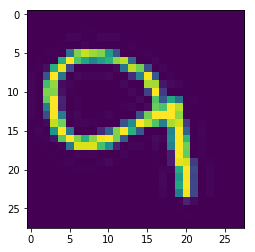

In [11]:
USPS_img_array, USPS_label_array = get_my_usps_data()

In [12]:
mnist.test.labels

array([[ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [13]:
USPS_label_array

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [ ]:
USPS_label_array